# Tritonlytics Verbatims - ULMFiT Language Model

Experiments related to building a LM for survey comments captured in the Tritonlytics survey delivery system

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
import datetime, pdb

from fastai.text import *   # Quick accesss to NLP functionality

from tritonlytics import Metrics as metrics_util, DataGeneration as dg_util, PandasUtil as pd_util
from tritonlytics.callbacks import RocAucEvaluation

import dill as pickle

import spacy
spacy_en = spacy.load('en')
spacy_es = spacy.load('es')

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
print(f'fastai version: {__version__}')

fastai version: 1.0.57


In [4]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


In [5]:
def convert_to_snakecase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('__', '_') 

## Configuration

In [6]:
# various default, LM, and classification paths
PATH = Path('../data')

LM_PATH = PATH/'lm'
CLS_PATH = PATH/'classification'
LM_LOGS_PATH = LM_PATH/'logs'

(LM_LOGS_PATH).mkdir(exist_ok=True)
(LM_PATH/'models').mkdir(parents=True, exist_ok=True)
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [7]:
# basic columns
lm_dtypes = { 
    'Id': int, 'QuestionAnsID': int, 'AnswerText': str, 'AnswerText_NonEnglish': str, 'Language': str,
    
    'SurveyID': int, 'SurveyTypeID': int, 'BenchmarkSurveyType': str, 'ClientId': str,'RspID': int,
    
    'QuestionCategoryAbbr': str, 'QuestionText': str, 'QuestionClass': str, 
    
    'QuestionCategoryID': float, 'QuestionReportAbbr': str, 'QuestionCategoryLabel': str, 
    'BenchmarkLevel1': str, 'BenchmarkLevel2': str, 'BenchmarkLevel3': str, 'ClientBenchmarkLevel': str,
    
    'GroupCode': float, 'GroupID': str, 
    'GroupLevel1Code': float, 'GroupLevel1Name': str,
    'GroupLevel2Code': float, 'GroupLevel2Name': str,
    'GroupLevel3Code': float, 'GroupLevel3Name': str,
    'GroupLevel4Code': float, 'GroupLevel4Name': str,
    'GroupLevel5Code': float, 'GroupLevel5Name': str,
    'GroupLevel6Code': float, 'GroupLevel6Name': str,
    'GroupLevel7Code': float, 'GroupLevel7Name': str,
    'GroupLevel8Code': float, 'GroupLevel8Name': str,
}

## Utility methods

In [8]:
# https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view : apostrophe lookup dict
appos_regex_repl = {
    r"\baren't\b" : "are not",
    r"\bcan't\b" : "cannot",
    r"\bcouldn't\b" : "could not",
    r"\bdidn't\b" : "did not",
    r"\bdoesn't\b" : "does not",
    r"\bdon't\b" : "do not",
    r"\bhadn't\b" : "had not",
    r"\bhasn't\b" : "has not",
    r"\bhaven't\b" : "have not",
    r"\bhe'd\b" : "he would",
    r"\bhe'll\b" : "he will",
    r"\bhe's\b" : "he is",
    r"\bi'd\b" : "I would",
    r"\bi'd\b" : "I had",
    r"\bi'll\b" : "I will",
    r"\bi'm\b" : "I am",
    r"\bisn't\b" : "is not",
    r"\bits\b" : "it is",
    r"\bit's\b" : "it is",
    r"\bit'll\b" : "it will",
    r"\bi've\b" : "I have",
    r"\blet's\b" : "let us",
    r"\bmightn't\b" : "might not",
    r"\bmustn't\b" : "must not",
    r"\bshan't\b" : "shall not",
    r"\bshe'd\b" : "she would",
    r"\bshe'll\b" : "she will",
    r"\bshe's\b" : "she is",
    r"\bshouldn't\b" : "should not",
    r"\bthat's\b" : "that is",
    r"\bthere's\b" : "there is",
    r"\bthey'd\b" : "they would",
    r"\bthey'll\b" : "they will",
    r"\bthey're\b" : "they are",
    r"\bthey've\b" : "they have",
    r"\bwe'd\b" : "we would",
    r"\bwe're\b" : "we are",
    r"\bweren't\b" : "were not",
    r"\bwe've\b" : "we have",
    r"\bwhat'll\b" : "what will",
    r"\bwhat're\b" : "what are",
    r"\bwhat's\b" : "what is",
    r"\bwhat've\b" : "what have",
    r"\bwhere's\b" : "where is",
    r"\bwho'd\b" : "who would",
    r"\bwho'll\b" : "who will",
    r"\bwho're\b" : "who are",
    r"\bwho's\b" : "who is",
    r"\bwho've\b" : "who have",
    r"\bwon't\b" : "will not",
    r"\bwouldn't\b" : "would not",
    r"\byou'd\b" : "you would",
    r"\byou'll\b" : "you will",
    r"\byou're\b" : "you are",
    r"\byou've\b" : "you have",
    r"\b're\b" : " are",
    r"\bwasn't\b" : "was not",
    r"\bwe'll\b" : "will",
    r"\bdidn't\b" : "did not",
    r"\btryin'\b" : "trying"
}

In [9]:
# based on https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing
emoji_str_repls = {
    "&lt;3": " love ",
    ":]" : " happy ",
    "=)" : " happy ",
    "8)": " happy ",
    ":-)": " happy ",
    ":)": " happy ",
    "(-:": " happy ",
    "(:": " happy ",
    ":&gt;": " happy ",
    ":')": " happy ",
    "(:" : " happy ",
    ":d": " laughing ",
    ":dd": " laughing ",
    ";-)" : " wink ",
    ";)": " wink ",
    ":p": " playful ",
    ":o" : " surprise ",
    ":-(": " sad ",
    ":(": " sad ",
    "=(" : " sad ",
    "):" : " sad ",
    ":/": " skeptical ",
    ":s": " skeptical ",
    ":-s": " skeptical ",
    "^^": " nervous ",
    "^_^": " nervous ",
    "-_-" : " shame ",
}

In [10]:
spelling_regex_repls = {
    # abbreviations
    r"\bacctg\b" : "acct",
    r"\badd'l\b" : "additional",
    r"\br\s\b": "are",
    r"\bu\s\b": "you ",
    r"\b\sm\s\b ": "am",
    r"'cause\b" : "because",
    r"\b(ha)+\b": "haha",
    r"\b(he)+\b": "haha",
    r"\bya+y\b": "yay",
    r"\bwa+y\b": "way",
    r"\bf'real\b" : "for real",
    r"\bgr8\b" : "great",
    r"\bintl\b" : "int'l",
    # common misspellings
    r"\bbailable\b" : "available",
    r"\babilty\b" : "ability",
    r"\babsolutly\b" : "absolutely",
    r"\babsoultely\b" : "absolutely",
    r"\bacces\b" : "access",
    r"\baccesability\b" : "accessibility",
    r"\baccesbility\b" : "accessibility",
    r"\baccesibility\b" : "accessibility",
    r"\baccessability\b" : "accessibility",
    r"\baccessbility\b" : "accessibility",
    r"\baccesable\b" : "accessible",
    r"\baccesible\b" : "accessible",
    r"\baccessable\b" : "accessible",
    r"\bacessible\b" : "accessible",
    r"\bassessable\b" : "availability",
    r"\baccidently\b" : "accidentally",
    r"\baccomadate\b" : "accommodate",
    r"\baccomdate\b" : "accommodate",
    r"\baccomidate\b" : "accommodate",
    r"\baccomodate\b" : "accommodate",
    r"\baccomadating\b" : "accommodating",
    r"\baccomidating\b" : "accommodating",
    r"\baccomodating\b" : "accommodating",
    r"\baccomadations\b" : "accommodations",
    r"\baccomodation\b" : "accommodation",
    r"\baccouting\b" : "accounting",
    r"\baccross\b" : "across",
    r"\badd'l\b" : "additional",
    r"\badditonal\b" : "additional",
    r"\baddtionally\b" : "additionally",
    r"\badminstration\b" : "administration",
    r"\badminstrative\b" : "administrative",
    r"\badminstrator\b" : "administrator",
    r"\badress\b" : "address",
    r"\badvancment\b" : "advancement",
    r"\badvertized\b" : "advertised",
    r"\bafforable\b" : "affordable",
    r"\bafordable\b" : "affordable",
    r"\bafterall\b" : "after all",
    r"\bafterhours\b" : "after hours",
    r"\baggresive\b" : "aggressive",
    r"\bagressive\b" : "aggressive",
    r"\bagressions\b" : "aggressions",
    r"\balittle\b" : "a little",
    r"\balll\b" : "all",
    r"\balloted\b" : "allotted",
    r"\ballthough\b" : "although",
    r"\balthought\b" : "although",
    r"\ballways\b" : "always",
    r"\balos\b" : "also",
    r"\balot\b" : "a lot",
    r"\balotted\b" : "allotted",
    r"\bammount\b" : "amount",
    r"\bammounts\b" : "amounts",
    r"\bamoung\b" : "among",
    r"\bamoungst\b" : "amongst",
    r"\bannouncment\b" : "announcement",
    r"\baparments\b" : "apartments",
    r"\bapparrel\b" : "apparel",
    r"\bappartment\b" : "apartment",
    r"\bappriciate\b" : "appreciate",
    r"\bassitance\b" : "assistance",
    r"\bassitant\b" : "assistant",
    r"\batleast\b" : "at least",
    r"\battentative\b" : "attentive",
    r"\battrocious\b" : "atrocious",
    r"\bavaiable\b" : "available",
    r"\bavaible\b" : "available",
    r"\bavailabe\b" : "available",
    r"\bavailble\b" : "available",
    r"\bavailiable\b" : "available",
    r"\bavailible\b" : "available",
    r"\bavaliable\b" : "available",
    r"\bavalible\b" : "available",
    r"\bavilable\b" : "available",
    r"\bavailiability\b" : "availability",
    r"\bavailabiltiy\b" : "availability",
    r"\bavailabilty\b" : "availability",
    r"\bavailablility\b" : "availability",
    r"\bavailablity\b" : "availability",
    r"\bavailibility\b" : "availability",
    r"\bavaliability\b" : "availability",
    r"\bavaliablity\b" : "availability",
    r"\bavalibility\b" : "availability",
    r"\bactivies\b" : "activities",
    r"\bactivites\b" : "activities",
    r"\bactualy\b" : "actually",
    r"\bacutally\b" : "actually",
    r"\bammenities\b" : "amenities",
    r"\bantoher\b" : "another",
    r"\bassitant\b" : "assistant",
    r"\baswell\b" : "as well",
    r"\baweful\b" : "awful",
    r"\bawfull\b" : "awful",
    r"\bawsome\b" : "awesome",
    r"\bbeacuse\b" : "because",
    r"\bbearly\b" : "barely",
    r"\bbeaurocracy\b" : "bureaucracy",
    r"\bbeaurocratic\b" : "bureaucratic",
    r"\bbecasue\b" : "because",
    r"\bbecuase\b" : "because",
    r"\bbecuse\b" : "because",
    r"\bbefor\b" : "before",
    r"\bbeggining\b" : "beginning",
    r"\bbegining\b" : "beginning",
    r"\bbeleive\b" : "believe",
    r"\bbelive\b" : "believe",
    r"\bbenificial\b" : "beneficial",
    r"\bbenifit\b" : "benefit",
    r'\bbugetary\b' : "budgetary",
    r'\bbuiding\b' : "building",
    r'\bbuidling\b' : "building",
    r'\bbuisness\b' : "business",
    r'\bbuliding\b' : "building",
    r"\bbureacracy\b" : "bureaucracy",
    r"\bburitto\b" : "burrito",
    r"\bbussiness\b" : "business",
    r"\bcalender\b" : "calendar",
    r"\bcan;t\b" : "can't",
    r"\bcasher\b" : "cashier",
    r'\bcatagories\b' : "categories",
    r'\bcatagory\b' : "category",
    r"\bcheapter\b" : "cheaper",
    r"\bcheeper\b" : "cheaper",
    r'\bclasss\b' : "clas",
    r'\bclassses\b' : "classes",
    r"\bcleaniness\b" : "cleanliness",
    r"\bcmapus\b" : "campus",
    r'\bcofee\b' : "coffee",
    r'\bcoffe\b' : "coffee",
    r'\bcollegue\b' : "colleague",
    r'\bcoment\b' : "comment",
    r'\bcoments\b' : "comments",
    r'\bcomming\b' : "coming",
    r'\bcommittment\b' : "commitment",
    r'\bcommment\b' : "comment",
    r'\bcommuication\b' : "communication",
    r'\bcommunter\b' : "commuter",
    r'\bcommunters\b' : "commuters",
    r'\bcomotion\b' : "commotion",
    r'\bcomparision\b' : "comparison",
    r'\bcompatability\b' : "compatibility",
    r'\bcompatable\b' : "compatible",
    r'\bcompetative\b' : "competitive",
    r'\bcompetetive\b' : "competitive",
    r'\bcompetive\b' : "competitive",
    r'\bcompletly\b' : "completely",
    r"\bcomraderie\b" : "camaraderie",
    r'\bcomradery\b' : "camaraderie",
    r'\bcomunication\b' : "communication",
    r'\bcomunity\b' : "community",
    r'\bconcious\b' : "conscious",
    r'\bcondusive\b' : "conducive",
    r'\bconection\b' : "connection",
    r"\bconfortable\b" : "comfortable",
    r'\bconsistant\b' : "consistent",
    r'\bconsistantly\b' : "consistently",
    r'\bconsistenly\b' : "consistently",
    r'\bcontinously\b' : "continuously",
    r'\bcontruction\b' : "construction",
    r'\bconveinent\b' : "convenient",
    r'\bconveinient\b' : "convenient",
    r'\bconveniant\b' : "convenient",
    r'\bconveniece\b' : "convenience",
    r'\bconveninent\b' : "convenient",
    r'\bconvienance\b' : "convenience",
    r'\bconvienant\b' : "convenient",
    r'\bconvience\b' : "convenience",
    r'\bconvienence\b' : "convenience",
    r'\bconvienent\b' : "convenient",
    r'\bconvienet\b' : "convenient",
    r'\bconvienience\b' : "convenience",
    r'\bconvienient\b' : "convenient",
    r'\bconvient\b' : "convenient",
    r'\bconviently\b' : "conveniently",
    r'\bconvinence\b' : "convenience",
    r'\bconvinent\b' : "convenient",
    r'\bconvinience\b' : "convenience",
    r'\bconvinient\b' : "convenient",
    r'\bcorteous\b' : "courteous",
    r'\bcostodial\b' : "custodial",
    r'\bcoureous\b' : "courteous",
    r'\bcourtis\b' : "courteous",
    r'\bcouteous\b' : "courteous",
    r'\bcovenient\b' : "convenient",
    r'\bcroweded\b' : "crowded",
    r'\bcurteous\b' : "courteous",
    r'\bcurtesy\b' : "courtesy",
    r'\bcurtious\b' : "courteous",
    r"\bdeaprtment\b" : "department",
    r"\bdecission\b" : "decision",
    r'\bdefinately\b' : "definitely",
    r'\bdefinetely\b' : "definitely",
    r'\bdefinetly\b' : "definitely",
    r'\bdefinitley\b' : "definitely",
    r'\bdefinitly\b' : "definitely",
    r'\bdelievered\b' : "delivered",
    r'\bdeliverers\b' : "deliveries",
    r'\bdeparment\b' : "department",
    r'\bdeparments\b' : "department",
    r'\bdepartement\b' : "department",
    r"\bdepartment\(s\b" : "departments",
    r'\bdepartmet\b' : "department",
    r'\bdepratment\b' : "department",
    r"\bdeptartment\b" : "department",
    r'\bdescrimination\b' : "discrimination",
    r'\bdesireable\b' : "desirable",
    r"\bdiffernt\b" : "different",
    r"\bdiffrent\b" : "different",
    r'\bdinig\b' : "dining",
    r'\bdirverse\b' : "diverse",
    r'\bdisapointed\b' : "disappointed",
    r'\bdisapointing\b' : "disappointing",
    r'\bdisasterous\b' : "disastrous",
    r'\bdisatisfied\b' : "dissatisfied",
    r'\bdisbursment\b' : "disbursement",
    r'\bdisbursments\b' : "disbursements",
    r'\bdiscretely\b' : "discreetly",
    r'\bdiscusting\b' : "disgusting",
    r'\bdisfunctional\b' : "dysfunctional",
    r'\bdispensors\b' : "dispensers",
    r'\bdispersement\b' : "disbursement",
    r'\bdissapointed\b' : "disappointed",
    r'\bdissapointing\b' : "disappointing",
    r'\bdissapointment\b' : "disappointment",
    r'\bdissappointed\b' : "disappointed",
    r'\bdissappointing\b' : "disappointing",
    r'\bdissatified\b' : "dissatisfied",
    r'\bdiveristy\b' : "diversity",
    r'\bdivison\b' : "division",
    r'\bdivsion\b' : "division",
    r"\bdoens't\b" : "doesn't",
    r"\bdoes't\b" : "doesn't",
    r"\bdoesn;t\b" : "doesn't",
    r"\bdon;t\b" : "don't",
    r'\bdonot\b' : "do not",
    r"\bdosen't\b" : "doesn't",
    r"\bdosent\b" : "doesn't",
    r'\bdumbells\b' : "dumbbells",
    r'\bdurring\b' : "during",
    r"\beatting\b" : "eating",
    r"\beduation\b" : "education",
    r'\beffeciency\b' : "efficiency",
    r'\beffecient\b' : "efficient",
    r'\befficency\b' : "efficiency",
    r'\befficent\b' : "efficient",
    r'\beffiecient\b' : "efficient",
    r'\beimplying\b' : "implying",
    r'\bembarassed\b' : "embarrassed",
    r'\bembarassing\b' : "embarrassing",
    r'\bembarassment\b' : "embarrassment",
    r'\bemploee\b' : "employee",
    r'\bemploye\b' : "employee",
    r'\bemployee\(s\b' : "employees",
    r'\bemployeed\b' : "employed",
    r'\bemployement\b' : "employment",
    r'\bemployes\b' : "employees",
    r'\bemployess\b' : "employees",
    r'\bemplyee\b' : "employee",
    r'\bemplyees\b' : "employees",
    r'\bempolyees\b' : "employees",
    r'\bencoutered\b' : "encountered",
    r'\benought\b' : "enough",
    r'\benrollement\b' : "enrollment",
    r'\benviorment\b' : "environment",
    r'\benviornment\b' : "environment",
    r'\benvirnment\b' : "environment",
    r'\benviroment\b' : "environment",
    r'\benvironement\b' : "environment",
    r'\bequiped\b' : "equipped",
    r'\bespcially\b' : "especially",
    r'\bespecailly\b' : "especially",
    r'\bespecialy\b' : "especially",
    r'\bespeically\b' : "especially",
    r"\besthetically\b" : "aesthetically ",
    r"\bethinicity\b" : "ethnicity",
    r"\bevaulation\b" : "evaluation",
    r"\beventhough\b" : "even though",
    r'\beverday\b' : "every day",
    r'\beverthing\b' : "everything",
    r'\beveryones\b' : "everyones",
    r'\beverythings\b' : "everythings",
    r'\beveryway\b' : "every way",
    r'\beveyone\b' : "everyone",
    r'\beveything\b' : "everything",
    r'\bevrything\b' : "everything",
    r'\bexcelent\b' : "excellent",
    r'\bexcellant\b' : "excellent",
    r'\bexellent\b' : "excellent",
    r'\bexhorbitant\b' : "exorbitant",
    r'\bexistance\b' : "existence",
    r'\bexpecially\b' : "especially",
    r'\bexpensice\b' : "expensive",
    r'\bexpereince\b' : "experience",
    r'\bexperiance\b' : "experience",
    r'\bexperince\b' : "experience",
    r'\bexpierence\b' : "experience",
    r'\bexpirence\b' : "experience",
    r'\bexplaination\b' : "explanation",
    r'\bexremely\b' : "extremely",
    r'\bextemely\b' : "extremely",
    r'\bextention\b' : "extension",
    r'\bextermely\b' : "extremely",
    r'\bextreamly\b' : "extremely",
    r'\bextrememly\b' : "extremely",
    r'\bextremly\b' : "extremely",
    r"\bfacilites\b" : "facilities",
    r'\bfacilties\b' : "facilities",
    r'\bfacilty\b' : "facility",
    r'\bfaculity\b' : "faculty",
    r'\bfacutly\b' : "faculty",
    r'\bfiancial\b' : "financial",
    r"\bfinacial\b" : "financial",
    r"\bfirendly\b" : "friendly",
    r'\bflexability\b' : "flexibility",
    r'\bflexibilty\b' : "flexibility",
    r'\bflexiblity\b' : "flexibility",
    r"\bflourescent\b" : "fluorescent",
    r'\bfreindly\b' : "friendly",
    r'\bfreqency\b' : "frequency",
    r'\bfreqent\b' : "frequent",
    r'\bfriednly\b' : "friendly",
    r'\bfrusterating\b' : "frustrating",
    r'\bfrusturating\b' : "frustrating",
    r'\bfustrating\b' : "frustrating",
    r'\bgovenor\b' : "governor",
    r"\bgraffitti\b" : "graffiti",
    r"\bgrafitti\b" : "graffiti",
    r"\bgreatful\b" : "grateful",
    r"\bguarenteed\b" : "guaranteed",
    r"\bguidlines\b" : "guidelines",
    r"\bguranteed\b" : "guaranteed",
    r"\bhappend\b" : "happened",
    r'\bharrass\b' : "harass",
    r'\bharrassed\b' : "harassed",
    r'\bharrassing\b' : "harassing",
    r'\bharrassment\b' : "harassment",
    r"\bhavn't\b" : "haven't",
    r'\bhealtheir\b' : "healthier",
    r'\bhealthly\b' : "healthy",
    r'\bhealtier\b' : "healthier",
    r'\bhealty\b' : "healthy",
    r'\bheathy\b' : "healthy",
    r'\bheirarchy\b' : "hierarchy",
    r'\bhelful\b' : "helpful",
    r'\bhelpfull\b' : "helpful",
    r'\bhelpul\b' : "helpful",
    r'\bhighschool\b' : "high school",
    r'\bhighschools\b' : "high schools",
    r'\bhorendous\b' : "horrendous",
    r'\bhorible\b' : "horrible",
    r'\bhouseing\b' : "housing",
    r'\bi"m\b' : "i'm",
    r'\bi"ve\b' : "i've",
    r'\bimplimented\b' : "implemented",
    r'\bimporve\b' : "improve",
    r'\bimposible\b' : "impossible",
    r'\bimprovment\b' : "improvement",
    r'\bimprovments\b' : "improvements",
    r'\bincompetant\b' : "incompetent",
    r'\binconsistant\b' : "inconsistent",
    r'\binconveinent\b' : "nconvenient",
    r'\binconvience\b' : "inconvenience",
    r'\binconvienent\b' : "nconvenient",
    r'\binconvienient\b' : "nconvenient",
    r'\binconvient\b' : "nconvenient",
    r'\binconvinient\b' : "nconvenient",
    r'\bindentify\b' : "identify",
    r'\bindependant\b' : "independent",
    r'\bindividual\(s\b' : "individuals",
    r'\binforced\b' : "enforced",
    r'\binformaiton\b' : "information",
    r'\binformtion\b' : "information",
    r'\binfront\b' : "in front",
    r'\binnout\b' : "in-n-out",
    r'\binsentive\b' : "incentive",
    r'\binsufficent\b' : "insufficient",
    r'\binterenet\b' : "internet",
    r'\binterent\b' : "internet",
    r'\bintermural\b' : "intramural",
    r'\bintramurals\b' : "intramurals",
    r'\binvironment\b' : "environment",
    r'\bissue\(s\b' : "issues",
    r'\bit;s\b' : "it's",
    r'\bitem\(s\b' : "items",
    r"\bjob\(s\b" : "jobs",
    r'\bknowledable\b' : "knowledgeable",
    r'\bknowledeable\b' : "knowledgeable",
    r'\bknowledegable\b' : "knowledgeable",
    r'\bknowledgable\b' : "knowledgeable",
    r'\bknowledgably\b' : "knowledgeably",
    r'\bknowledgeably\b' : "knowledgeably",
    r'\bknowledgeble\b' : "knowledgeable",
    r'\bknowlegable\b' : "knowledgeable",
    r'\bknowlegeable\b' : "knowledgeable",
    r'\bliek\b' : "like",
    r'\blieke\b' : "like",
    r'\blimted\b' : "limited",
    r'\bmaintainance\b' : "maintenance",
    r'\bmaintaince\b' : "maintenance",
    r'\bmaintainence\b' : "maintenance",
    r'\bmaintanance\b' : "maintenance",
    r'\bmaintance\b' : "maintenance",
    r'\bmaintanence\b' : "maintenance",
    r'\bmaintenace\b' : "maintenance",
    r'\bmaintenances\b' : "maintenance",
    r'\bmaintence\b' : "maintenance",
    r'\bmaintenece\b' : "maintenance",
    r'\bmaintenence\b' : "maintenance",
    r'\bmaitenance\b' : "maintenance",
    r'\bmanager\(s\b' : "managers",
    r'\bmanagment\b' : "management",
    r'\bmanangement\b' : "management",
    r'\bmangement\b' : "management",
    r'\bmangers\b' : "managers",
    r'\bmanuever\b' : "maneuver",
    r'\bmintues\b' : "minutes",
    r'\bmoblie\b' : "mobile",
    r'\bmulitple\b' : "multiple",
    r'\bn\?a\b' : "n/a",
    r'\bna\b' : "n/a",
    r'\bneccessary\b' : "necessary",
    r'\bnecesary\b' : "necessary",
    r'\bneedes\b' : "needs",
    r'\bneeed\b' : "need",
    r'\bnonexistant\b' : "nonexistent",
    r'\bnothig\b' : "nothing",
    r'\bnothjng\b' : "nothing",
    r'\bnoticable\b' : "noticeable",
    r'\bobsurd\b' : "absurd",
    r'\bocassional\b' : "occasional",
    r'\boccassion\b' : "occasion",
    r'\boccassional\b' : "occasional",
    r'\boccassionally\b' : "occasionally",
    r'\boccassions\b' : "occasions",
    r'\boccations\b' : "occasions",
    r'\boccurances\b' : "occurrences",
    r'\boccured\b' : "occurred",
    r'\boccuring\b' : "occurring",
    r'\boccurr\b' : "occur",
    r'\bofcourse\b' : "of course",
    r'\bofferred\b' : "offered",
    r'\bopinon\b' : "opinion",
    r'\bopitions\b' : "options",
    r'\boportunities\b' : "opportunities",
    r'\bopperation\b' : "operation",
    r'\boppertunities\b' : "opportunities",
    r'\boppinion\b' : "opinion",
    r'\bopportunites\b' : "opportunities",
    r'\bopportunties\b' : "opportunities",
    r'\boppotunities\b' : "opportunities",
    r'\boppurtunities\b' : "opportunities",
    r'\boppurtunity\b' : "opportunity",
    r'\borgnized\b' : "organized",
    r'\boutragous\b' : "outrageous",
    r'\bpage\(s\b' : "pages",
    r'\bpakages\b' : "packages",
    r'\bparkibg\b' : "parking",
    r'\bparkig\b' : "parking",
    r'\bparkign\b' : "parking",
    r'\bparkinglots\b' : "parking lots",
    r'\bpartime\b' : "part-time",
    r'\bparttime\b' : "part-time",
    r'\bpatroling\b' : "patrolling",
    r'\bpeopel\b' : "people",
    r'\bpermitt\b' : "permit",
    r'\bperson\(s\b' : "persons",
    r'\bpersonel\b' : "personnel",
    r'\bpersonell\b' : "personnel",
    r'\bpharamcy\b' : "pharmacy",
    r'\bpleasent\b' : "pleasant",
    r'\bplently\b' : "plenty",
    r'\bplesant\b' : "pleasant",
    r'\bpositon\b' : "position",
    r'\bposses\b' : "possess",
    r'\bpossition\b' : "position",
    r'\bpostion\b' : "position",
    r'\bpostions\b' : "positions",
    r'\bpostition\b' : "position",
    r'\bpostive\b' : "positive",
    r'\bpractioner\b' : "practitioner",
    r'\bpractioners\b' : "practitioners",
    r'\bprefered\b' : "preferred",
    r'\bpreferrably\b' : "preferably",
    r'\bpreform\b' : "perform",
    r'\bpreforming\b' : "performing",
    r'\bpricess\b' : "prices",
    r'\bpriciples\b' : "principles",
    r'\bpricy\b' : "pricey",
    r'\bprking\b' : "parking",
    r'\bproceedures\b' : "procedures",
    r'\bprocurment\b' : "procurement",
    r'\bprofessionaly\b' : "professionally",
    r'\bproffessional\b' : "professional",
    r'\bproffit\b' : "profit",
    r'\bprofitt\b' : "profit",
    r'\bprogam\b' : "program",
    r'\bpromissed\b' : "promised",
    r'\bpublically\b' : "publicly",
    r'\bqucik\b' : "quick",
    r'\bquestion\(s\b' : "questions",
    r'\bquestionaire\b' : "questionnaire",
    r'\breall\b' : "really",
    r'\brealy\b' : "really",
    r'\breccomend\b' : "recommend",
    r'\breccommend\b' : "recommend",
    r'\breceieve\b' : "receive",
    r'\breciept\b' : "receipt",
    r'\breciepts\b' : "receipts",
    r'\brecieve\b' : "receive",
    r'\brecieved\b' : "received",
    r'\brecieves\b' : "receives",
    r'\brecieving\b' : "receiving",
    r'\brecived\b' : "received",
    r'\brecomend\b' : "recommend",
    r'\brecomended\b' : "recommended",
    r'\brediculous\b' : "ridiculous",
    r'\brediculously\b' : "ridiculously",
    r'\brefered\b' : "referred",
    r'\brefering\b' : "referring",
    r'\bregeants\b' : "regents",
    r'\bregistar\b' : "regisrtar",
    r'\bregistars\b' : "regisrtars",
    r'\bregulary\b' : "regularly",
    r'\breimbursment\b' : "reimbursement",
    r'\breponse\b' : "response",
    r'\breponsive\b' : "responsive",
    r'\brepresentitive\b' : "representative",
    r'\breserach\b' : "research",
    r'\bresonable\b' : "reasonable",
    r'\bresouces\b' : "resources",
    r'\bresourses\b' : "resources",
    r'\bresponsed\b' : "responded",
    r'\bresponsibilites\b' : "responsibilites",
    r'\bresponsiblities\b' : "responsibilites",
    r'\bresponsiblity\b' : "responsibility",
    r'\brestaraunts\b' : "restaurants",
    r'\brestraunts\b' : "restaurants",
    r'\brestuarant\b' : "restaurant",
    r'\brestuarants\b' : "restaurants",
    r'\bresturant\b' : "restaurant",
    r'\bresturants\b' : "restaurants",
    r'\bridiculus\b' : "ridiculous",
    r'\briduculous\b' : "ridiculous",
    r'\broomate\b' : "roommate",
    r'\broomates\b' : "roommates",
    r'\bsaleries\b' : "salaries",
    r'\bsandwhich\b' : "sandwich",
    r'\bsandwhiches\b' : "sandwiches",
    r'\bsandwitches\b' : "sandwiches",
    r'\bsatifaction\b' : "satisfaction",
    r'\bsatified\b' : "satisfisatisfieded",
    r'\bsattelite\b' : "satellite",
    r'\bsceience\b' : "science",
    r'\bschedual\b' : "schedule",
    r'\bseemless\b' : "seamless",
    r'\bselction\b' : "selection",
    r'\bsenority\b' : "seniority",
    r'\bsensative\b' : "sensitive",
    r'\bsensored\b' : "censored",
    r'\bseperate\b' : "separate",
    r'\bseperation\b' : "separation",
    r'\bserivce\b' : "service",
    r'\bserivces\b' : "services",
    r'\bserive\b' : "service",
    r'\bserives\b' : "services",
    r'\bservicesi\b' : "services",
    r'\bservidces\b' : "services",
    r'\bservive\b' : "survive",
    r'\bservives\b' : "survives",
    r'\bseverly\b' : "severely",
    r'\bsevice\b' : "service",
    r'\bsevices\b' : "services",
    r'\bshcool\b' : "school",
    r'\bshoud\b' : "should",
    r'\bshoudl\b' : "should",
    r'\bshutttle\b' : "shuttle",
    r'\bsimiliar\b' : "similar",
    r'\bsomeitmes\b' : "sometimes",
    r'\bsomeone\(s\b' : "someones",
    r'\bsomeones\b' : "someones",
    r'\bsometiems\b' : "sometimes",
    r'\bsomone\b' : "someone",
    r'\bsomthing\b' : "something",
    r'\bsophmore\b' : "sophomore",
    r'\bspecialy\b' : "especially",
    r'\bstafff\b' : "staff",
    r'\bstatment\b' : "statement",
    r'\bstong\b' : "strong",
    r'\bstongly\b' : "strongly",
    r'\bstoping\b' : "stopping",
    r'\bstrabucks\b' : "starbucks",
    r'\bstressfull\b' : "stressful",
    r'\bstructure\(s\b' : "structures",
    r'\bstucture\b' : "structure",
    r'\bstuctures\b' : "structures",
    r'\bstuden\b' : "student",
    r'\bstudent\(s\b' : "students",
    r'\bstudetns\b' : "students",
    r'\bstudnet\b' : "student",
    r'\bstudnets\b' : "students",
    r'\bsucess\b' : "success",
    r'\bsudent\b' : "student",
    r'\bsudents\b' : "students",
    r'\bsuperintendant\b' : "superintendent",
    r'\bsuperviser\b' : "supervisor",
    r'\bsupervisor\(s\b' : "supervisors",
    r'\bsupervisores\b' : "supervisors",
    r'\bsuport\b' : "support",
    r'\bsupples\b' : "supplies",
    r'\bsuppossed\b' : "supposed",
    r'\bsuprised\b' : "surprised",
    r'\bsuvey\b' : "survey",
    r'\bsytem\b' : "system",
    r'\bthats\b' : "that's",
    r"\bthe're\b" : "they're",
    r'\btheives\b' : "thieves",
    r'\bthiefs\b' : "thieves",
    r'\bthreating\b' : "threatening",
    r'\bthroughly\b' : "thoroughly",
    r'\bthrought\b' : "throughout",
    r'\bthroughtout\b' : "throughout",
    r'\btodays\b' : "today's",
    r'\btraing\b' : "training",
    r'\btrainning\b' : "training",
    r'\btranfers\b' : "transfers",
    r'\btransfered\b' : "transferred",
    r'\btransfering\b' : "transferring",
    r'\btransporation\b' : "transportation",
    r'\btransportaion\b' : "transportation",
    r'\btransportations\b' : "transportations",
    r'\btransportion\b' : "transportation",
    r'\btrashbags\b' : "trash bags",
    r'\btrashcans\b' : "trash cans",
    r'\btremedously\b' : "tremendously",
    r'\btshirt\b' : "t-shirt",
    r'\btshirts\b' : "t-shirts",
    r'\btution\b' : "tuition",
    r'\btutition\b' : "tuition",
    r'\bunaccessible\b' : "inaccessible",
    r'\bunconvenient\b' : "inconvenient",
    r'\bunecessary\b' : "unnecessary",
    r'\bunflexible\b' : "inflexible",
    r'\bunforseen\b' : "unforeseen",
    r'\buniverisity\b' : "university",
    r'\buniveristy\b' : "university",
    r'\buniverity\b' : "university",
    r'\bunknowledgeable\b' : "unknowledgable",
    r'\bunneccessary\b' : "unnecessary",
    r'\bunrealiable\b' : "unreliable",
    r'\buntill\b' : "until",
    r'\bunversity\b' : "university",
    r'\buseability\b' : "usability",
    r'\busefull\b' : "useful",
    r'\bususally\b' : "usually",
    r'\bvaccum\b' : "vacuum",
    r'\bvaccuum\b' : "vacuum",
    r'\bvaction\b' : "vacation",
    r'\bvacume\b' : "vacuum",
    r'\bvariaty\b' : "variety",
    r'\bvarities\b' : "varieties",
    r'\bvarity\b' : "variety",
    r'\bvegeterian\b' : "vegetarian",
    r'\bvegitarian\b' : "vegetarian",
    r'\bvegitarians\b' : "vegetarians",
    r'\bvegtables\b' : "vegetables",
    r'\bventillation\b' : "ventilation",
    r'\bveriety\b' : "variety",
    r'\bvisted\b' : "visited",
    r'\bvistor\b' : "visitor",
    r'\bvistors\b' : "visitors",
    r'\bweeekends\b' : "weekends",
    r'\bwierd\b' : "weird",
    r'\bwirless\b' : "wireless",
    r'\bwithdrawl\b' : "withdrawal",
    r'\bwoudl\b' : "would",
    r"\bwoudn't\b" : "wouldn't",
    r"\bthier\b" : "their",
    r"\bappartments\b" : "apartments",
    r"\bbenifits\b" : "benefits",
    r"\bexistant\b" : "existent",
    r"\bsaftey\b" : "safety",
    r'\bdon"t\b' : "don't",
}

In [11]:
weirdchar_str_repls = {
    "#39;" : "'",   
    'amp;' : '&',   
    '#146;' : "'",   
    'nbsp;' : ' ',   
    '#36;' : '$',   
    '\\n' : "\n",   
    'quot;' : "'",   
    '’' : "'",   
    "´" : "'",
    "`" : "'",
    '`' : "'", 
    '´' : "'", 
    '“' : '"',   
    '”' : '"',   
    '<br />' : "\n",   
    '\\"' : '"',   
    '<unk>' : 'u_n',   
    ' @.@ ' : '.',   
    ' @-@ ' : '-',   
    '\\' : ' \\ ',   
    '•' : '-'
}

In [12]:
# does regex replace making the substitution the same case
def re_replace(word, replacement, text):
    def func(match):
        g = match.group()
        if g.islower(): return replacement.lower()
        if g.istitle(): return replacement.title()
        if g.isupper(): return replacement.upper()
        return replacement      
    
    return re.sub(word, func, text, flags=re.I)

# define regex and string replacements
re_repls = {}  # e.g., { **spelling_regex_repls } 
str_repls = {} # e.g., { **weirdchar_str_repls }

def make_replacements(t:str) -> str:
    # replace based on regexs (keeping case) and then strings
    for k, v in re_repls.items(): t = re_replace(k, v, t)
    for k, v in str_repls.items(): t = t.replace(k, t)
    return t

# ensure am|pm is considered it own token (7:00pm > 7:00 pm, 7am-10pm > 7 am - 10 pm))
def fix_ampm(t:str) -> str:
    re_ampm = re.compile(r'(\d+)(am|pm|am\-|pm\-|a\.m\.|p\.m\.|a\.m\.\-|p\.m\.\-)')    
    return re_ampm.sub(r'\1 \2 ', t)

# try to handle places where a new sentence doesn't begin with a space (e.g., I like dogs.I like cats)
# without breaking apart things like urls and emails
def fix_sentence_ends(t:str) -> str:
    re_sentend = re.compile(r'(?<!www)\.((?!com|edu|org|net|m\b)[a-zA-Z]+)(?!(@|\.(com|edu|org|net)))\b') 
    return re_sentend.sub(r'. \1 ', t)

# separate hyphen|tilde if it is at beginning of letter/digit
def fix_hyphenated_words(t:str) -> str:
    re_hypword = re.compile(r'\s(\-+|~+)([a-zA-Z0-9])')
    return re_hypword.sub(r' \1 \2', t)


## Language Model

The goal of the language model is to predict the next word.  The idea is simple: an LM learns how English works which can in turn be helpful in predicting sentiment

In [13]:
chunksize = 24000
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

bptt = 70
bsz = 128 #80
wd = 1e-7

# define tokenization, numericalization, and data parameters (tokeneization, text columns, etc..)
include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

max_vocab = 60000
min_freq = 2

corpus_cols = ['AnswerText']  # ['QuestionText', 'AnswerText']
data_suf = ''                 # '_qst+ans' 

In [14]:
train_df = pd.read_csv(LM_PATH/'train.csv', low_memory=False)
valid_df = pd.read_csv(LM_PATH/'test.csv', low_memory=False)

In [15]:
# remove rows where there are nulls in corpus cols
prev_lens = len(train_df), len(valid_df)

train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

print(f'Removed rows: {prev_lens[0]-len(train_df), prev_lens[1] - len(valid_df)}')

Removed rows: (0, 0)


In [16]:
# prepend custom tokenization rules to defaults
custom_tok_rules = defaults.text_pre_rules + [make_replacements, fix_ampm, fix_sentence_ends, fix_hyphenated_words]

# use this customized Tokenizer for qualitative data
tokenizer = Tokenizer(pre_rules=custom_tok_rules)

In [17]:
lm_processor = [
    TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                      mark_fields=include_fld_tok, include_bos=include_bos_tok, include_eos=include_eos_tok),
    NumericalizeProcessor(vocab=None, max_vocab=max_vocab, min_freq=min_freq)
]

data_lm = (ItemLists(path=LM_PATH,
                     train=TextList.from_df(train_df, path=LM_PATH, cols=corpus_cols, processor=lm_processor),
                     valid=TextList.from_df(valid_df, path=LM_PATH, cols=corpus_cols, processor=lm_processor)
                    )
           .label_for_lm()
           .databunch()
          )

data_lm.save(f'data_lm{data_suf}.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
data_lm = load_data(LM_PATH, f'data_lm{data_suf}.pkl', bs=bsz, bptt=bptt)

In [19]:
# save vocab for classifiers
pickle.dump(data_lm.train_ds.vocab, open(LM_PATH/f'vocab{data_suf}.pkl','wb'))

Look at the databunch

In [20]:
data_lm.show_batch()

idx,text
0,"service center xxbos xxmaj train staff to know how to do their jobs . i went in one day to purchase a permit and their system crashed . xxmaj another time i was issued a temporary permit ( as a new employee ) . i returned because the permit i was issued was only for 5 days , when the temporary permit is suppose to be for a longer time"
1,"suggestions . xxbos i love the off site parking . xxmaj it better meets my needs budget - wise than the on campus parking . xxbos xxmaj when there 's actually a parking spot for students . xxbos xxmaj bottom line : xxmaj food is extremely overpriced and dining halls are extremely stingy in the amount of food they serve you . xxmaj for instance , when xxup ovt is"
2,"having to help get these students registered across campus . xxmaj and for the students it makes it hard for them to get the classes they need . xxbos xxmaj really hard to figure out where to park based on the website , as well as what my parking rate will be and if i , as a grad student , have other options for where to park and how"
3,provide policies that do not contradict productivity and reward positive impacts in the work enviroment xxbos xxmaj very knowledgeable staff . xxmaj there is always someone that i can reach out to that has expertise on what i need help with . xxbos xxmaj at xxmaj starbucks to be more attentive to the customers . i know it is busy but sometimes they do not acknowledge customers . xxbos i
4,despite repeated complaints . xxbos provide inventory lists and follow - ups via email . xxbos xxmaj more parking xxunk spaces for 3 hours - the $ 8 dollar parking fee for all day may not be worth it if i only go for less than 3 hours but more than 1 hour . xxbos xxmaj julia xxmaj halladay who is not there anymore was the only person i could


In [21]:
data_lm.train_ds.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [22]:
print(len(data_lm.train_ds), len(data_lm.train_ds.vocab.itos))
print(len(data_lm.valid_ds), len(data_lm.valid_ds.vocab.itos))

532302 39904
59145 39904


In [23]:
batch = next(iter(data_lm.train_dl))
print(batch[0].size()), print(batch[1].size())

torch.Size([128, 70])
torch.Size([128, 70])


(None, None)

In [24]:
' '.join([ data_lm.train_ds.vocab.itos[idx] for idx in batch[0][0,:] ])

". xxmaj the employee at the desk said they did n't issue the permit . xxmaj seriously ? ! xxmaj how did manage to get the permit then ? xxbos xxmaj not many choice of the food we can pick at the dinning hall , also , the food quality is not as fine as i expect , and the price is not reasonable . xxbos xxmaj adding more tables"

To create a backwards databunch ...

In [25]:
data_lm_bwd = load_data(LM_PATH, f'data_lm{data_suf}.pkl', bs=bsz, bptt=bptt, backwards=True)
data_lm_bwd.show_batch()

idx,text
0,xxmaj andrew xxmaj dr. xxmaj xxbos subjects these on attended ever have i discussions best the of some are they . department the in happening from this like anything keeps it and meetings staff our of all during this like issue address director my that say to have would i xxbos healthy and good so is food the xxmaj xxbos nothing xxbos textbook a finding in helpful are people and
1,"like d i xxbos ! helpful extremely been has candi xxmaj xxbos early that close n't do markets xxmaj xxbos issues personal with direction of source great a provide and helpful very is staff the xxbos . be to needs it than difficult more it make restrictions xxmaj . hours work best determine to office each allow , . dept across guidelines general xxmaj . trusted feel n't do i"
2,"n't do i , sometimes because , degrees xxmaj 64 at open be should courts food more xxmaj . lower bit a be should prices xxmaj xxbos . answers with us to back get to someone for wait to have n't do we so , rules and guidelines clear are there where areas in efficient and helpful be would assistance / information online xxmaj xxbos speed the xxmaj xxbos ."
3,in - log and site business max xxmaj office xxmaj the use we when even xxmaj . use to difficult very is site storehouse the xxmaj xxbos . goes it where know will we so package the on is it orders that person the of name the that supplies office xxmaj or stores through ordering when xxmaj . lawson xxmaj in things find to able be xxmaj \n r
4,"i , example for , confusing website their find also i . call to have you ; there person a to speak n't ca you that frustrating is it xxmaj xxbos lights more xxunk be to need shops titan the xxmaj xxbos comment no xxmaj xxbos . experienced less is but service lip in good basically or fluent maybe is who applicant an accepting than rather knowledgeable and experienced more"


### Configure a forward or backwards run

In [51]:
backwards = True

m_pre = 'bwd_' if (backwards) else 'fwd_'
data = load_data(LM_PATH, f'data_lm{data_suf}.pkl', bs=bsz, bptt=bptt, backwards=backwards)

### Build the LanguageModel (baseline)

Our Language Model (LM) is composed of a backbone and a custom head.  The backbone is initialized with the weights of an LM trained on a larger corpus, [Wikitext 103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) and the custom head is a linear classifier.  The vocabulary of the two datasets are slightly different, so when loading the weights, we take care to put the embedding weights at the right place, and we randomly initiliaze the embeddings for words in our vocabulary that weren't in the wikitext-103 vocabulary of our pretrained model.

The pretrained model will be downloaded on first use. We also use **Mixed Precision** Trianing, which enables us to use a higher batch size by training part of our model in FP16 precision, and also speeds up trqining by a factor 2 to 3 on modern GPUs.

**bptt** (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

We setup the **dropouts** for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer (the `Learner` object is frozen by default)

We also keep track of the *accuracy* metric.

In [ ]:
try: learn.purge(); learn = None; gc.collect(); torch.cuda.empty_cache()
except: pass

In [56]:
learn = language_model_learner(data, arch=AWD_LSTM, drop_mult=0.7) #, alpha=2, beta=1)
learn = learn.to_fp16(clip=0.12)

# grad_clip = partial(GradientClipping, clip=0.12)
# csv_logger = partial(callbacks.CSVLogger, filename=f'{yyyymmdd}_{m_pre}lm_bestmodel{data_suf}')
best_model = partial(callbacks.SaveModelCallback, monitor='accuracy', mode='max', 
                     name=f'{m_pre}lm_bestmodel{data_suf}')

learn.callback_fns += [best_model]
learn.metrics = [accuracy]
learn.true_wd = True

In [57]:
best_model_path = LM_PATH/f'models/{m_pre}lm_bestmodel{data_suf}*'
!rm {best_model_path}

rm: cannot remove '../data/lm/models/bwd_lm_bestmodel*': No such file or directory


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


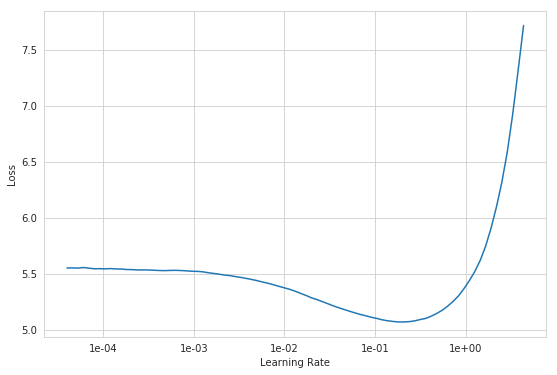

In [58]:
learn.lr_find(start_lr=1e-5, end_lr=1e+1, wd=wd)
learn.recorder.plot()

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [59]:
lr = 3e-2

In [60]:
%%time
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.082937,3.806565,0.329321,07:03


Better model found at epoch 0 with accuracy value: 0.32932090759277344.
CPU times: user 4min 52s, sys: 2min 13s, total: 7min 5s
Wall time: 7min 4s


In [61]:
learn.save(f'{m_pre}lm_last_ft{data_suf}')

In [62]:
# best model is loaded at conclusion of previous fit #learn = learn.load(f'{l_pre}lm_last_ft{exp_suffix}')

In [63]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


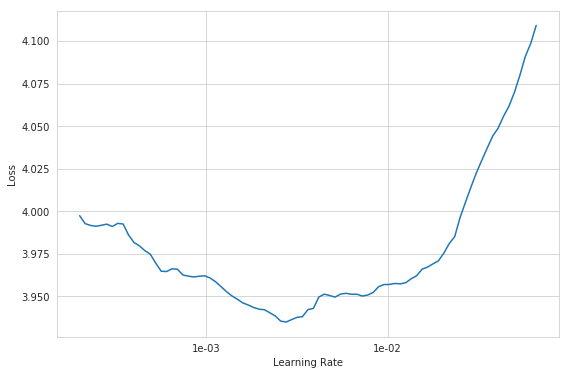

In [64]:
learn.lr_find(start_lr=1e-3/10, end_lr=1e-2*10, wd=wd)
learn.recorder.plot()

In [65]:
lr = 4e-3
# using discriminative
# lrs = np.array([lr/6, lr/3, lr, lr/2])

In [66]:
%%time
learn.fit_one_cycle(15, max_lr=slice(lr/10, lr), moms=(0.8,0.7), wd=wd)

# Notes:
# 08/27/2019 Answer Only (fwd): acc=0.3485 | loss=3.328849 ... (bwd): acc=0.3828 | loss=3.3445714
# 10/15/2019 Answer Only (fwd): acc=0.3493 | loss=3.3253813 ... (bwd): acc=0.3843 | loss=3.3392181

epoch,train_loss,valid_loss,accuracy,time
0,3.793325,3.661272,0.345276,08:15
1,3.676758,3.561811,0.356453,08:16
2,3.606529,3.493328,0.364470,08:17
3,3.548817,3.449289,0.369283,08:17
4,3.484219,3.415923,0.373160,08:17
5,3.443973,3.394410,0.376093,08:17
6,3.401623,3.376709,0.378023,08:16
7,3.359365,3.365059,0.379823,08:16
8,3.324296,3.355489,0.381028,08:17
9,3.282967,3.349270,0.382091,08:18


Better model found at epoch 0 with accuracy value: 0.3452763855457306.
Better model found at epoch 1 with accuracy value: 0.35645291209220886.
Better model found at epoch 2 with accuracy value: 0.3644697070121765.
Better model found at epoch 3 with accuracy value: 0.36928269267082214.
Better model found at epoch 4 with accuracy value: 0.373159795999527.
Better model found at epoch 5 with accuracy value: 0.3760925233364105.
Better model found at epoch 6 with accuracy value: 0.3780229389667511.
Better model found at epoch 7 with accuracy value: 0.3798225224018097.
Better model found at epoch 8 with accuracy value: 0.3810279667377472.
Better model found at epoch 9 with accuracy value: 0.38209086656570435.
Better model found at epoch 10 with accuracy value: 0.38306349515914917.
Better model found at epoch 11 with accuracy value: 0.38358354568481445.
Better model found at epoch 12 with accuracy value: 0.3840692639350891.
Better model found at epoch 13 with accuracy value: 0.3842030763626098

In [67]:
learn.save(f'{m_pre}lm{data_suf}')

In [68]:
learn.save_encoder(f'{m_pre}lm_enc{data_suf}')

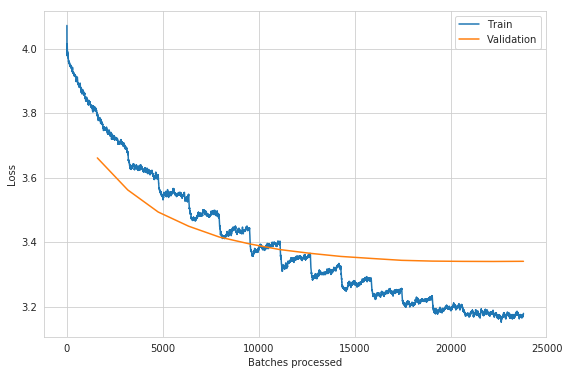

In [69]:
learn.recorder.plot_losses()

Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

See here: https://docs.fast.ai/tutorial.data.html#Language-modelling

In [70]:
learn.validate()

[3.3392181, tensor(0.3843)]

In [71]:
learn.show_results()

text,target,pred
. expenses monthly my cover to am i that adjustments same the make to forced not are people paid -,higher the xxmaj . reductions salary of brunt the taken has staff that feel i xxbos xxunk xxbos . ages,"high so so . ) salary and because the bear have department and seems i , . xxbos . campus"
xxmaj in members staff the of many with worked have i xxbos n xxbos bumps speed the dodging cars the,"all with hazard greater a make they and , bicycles on those for hazard a are they way- discovery xxmaj","all with especially safety a creates would xxmaj , cars for people for dangerous safety is bumps xxmaj the xxmaj"
a of high as be should parking of availability xxmaj . disgusting absolutely is this xxmaj . excuses xxup no,"xxup -- 7 / 24 , everyone for parking free and garages parking massive have outta we xxmaj . insulting","xxup are parking / 24 available day for parking enough xxmaj , parking more xxup to you xxmaj . campus"
streets campus on presence police consistent a xxbos . classes have i day every campus to mins 40 walk to,"having up end i typically xxmaj . students campus - off supporting to crucial is this , availability parking limited",have of end i . xxmaj . parking for off off for of closer is parking xxmaj campus parking of
how and communities of principles the between disconnect a be to seems there xxmaj xxbos . experience my from students,all with patient are they xxmaj . helpful and nice extremely are cashiers the of all xxmaj xxbos . merchandise,the to interacting and they xxmaj xxbos helpful and friendly very are staff the xxmaj all xxmaj xxbos . campus


In [ ]:
learn.export(file=f'{m_pre}export_lm{data_suf}.pkl')

#### Inference time (new in 1.40)  
See: https://docs.fast.ai/tutorial.inference.html#Language-modelling

In [73]:
def beam_search(learn, text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
                    sep:str=' ', decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text` using beam search."
        learn.model.reset()
        learn.model.eval()
        xb, yb = learn.data.one_item(text)
        nodes = None
        nodes = xb.clone()               # ([1, 6])
        scores = xb.new_zeros(1).float() # ([1])
        with torch.no_grad():
            for k in progress_bar(range(n_words), leave=False):
                out = F.log_softmax(learn.model(xb)[0][:,-1], dim=-1).float() # ([1, 39328]) > ([10, 39328]) > ([100, 39328])
                if no_unk: out[:,learn.data.vocab.stoi[UNK]] = -float('Inf')
                values, indices = out.topk(top_k, dim=-1)                     # ([1, 10]) > ([10, 10])) > ([100, 10])
                pdb.set_trace()
                scores = (-values + scores[:,None]).view(-1)                  # ([10]) > ([100]) > ([1000]) > (2000)
                
                indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(
                    nodes.size(0), top_k).contiguous().view(-1)               # ([10]) > ([100]) > ([1000]) > (2000)
                
                sort_idx = scores.argsort()[:beam_sz]                         #        >         > ([200]) > (200)
                scores = scores[sort_idx]
                
                # nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)) =>  ([1, 10, 6]) > ([10, 10, 7]) > ([100, 10, 8])
                # indices[:,:,None].expand(nodes.size(0),top_k,1),]       =>  ([1, 10, 1]) > ([10, 10, 1]) > ([100, 10, 1])
                
                nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2) # ([1, 10, 7]) > ([10, 10, 8]) > ([100, 10, 9])
                
                
                nodes = nodes.view(-1, nodes.size(2))[sort_idx]              # ([10, 7]) > ([10, 10, 8]) > ([200, 9])
                learn.model[0].select_hidden(indices_idx[sort_idx])
                xb = nodes[:,-1][:,None]
        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        return text + sep + sep.join(decoder(learn.data.vocab.textify([i.item() for i in nodes[node_idx][1:] ], 
                                                                     sep=None)))


In [14]:
backwards = False
data_suf = ''
m_pre = 'bwd_' if (backwards) else 'fwd_'

data = load_data(LM_PATH, f'data_lm{data_suf}.pkl', bs=bsz, bptt=bptt, backwards=backwards)

learn = language_model_learner(data, AWD_LSTM, pretrained=False).load(f'{m_pre}lm_bestmodel{data_suf}', 
                                                                      with_opt=False);

Later you you rebuild your learner and make predictions

In [15]:
learn = load_learner(LM_PATH, f'{m_pre}export_lm{data_suf}.pkl')

In [16]:
# print(learn.predict('The library needs to', n_words=40))
print(learn.beam_search('The library needs to', n_words=40, beam_sz=200))

The library needs to The library needs to have more spaces for students to study . It is very difficult to find a place to study , especially during midterm and final weeks . It is very difficult to find a place to sit and study


In [17]:
# print(learn.predict('The best thing about parking is', n_words=40))
print(learn.beam_search('The best thing about parking is ', n_words=40, beam_sz=200))

The best thing about parking is  The best thing about parking is the fact that i can park in a and b spots after 4:30 pm . i also like that i can park in a and b spots after 4:30 pm   and that i can park in a or b


In [18]:
# print(learn.predict('The worse thing about parking is', n_words=40))
print(learn.beam_search('The worse thing about parking is ', n_words=40, beam_sz=200))

The worse thing about parking is  The worse thing about parking is that there are so many " a " and " b " spots and not enough " s " spots . There are way too many " a " and " b " spots and not enough " s


## Getting document vectors from LM

In [27]:
backwards = False
m_pre = 'bwd_' if backwards else 'fwd_'
data_suf = ''

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:1


In [28]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype=lm_dtypes, parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df))

corpus_cols = ['AnswerText']  # ['QuestionText', 'AnswerText']

591447


In [29]:
inf_learn = None; gc.collect()

inf_learn = load_learner(LM_PATH, f'{m_pre}export_lm{data_suf}.pkl')
txt_procs = inf_learn.data.train_ds.processor

inf_learn.model = inf_learn.model.to(device)
inf_learn.model = inf_learn.model.eval()

### Predict by batch

In [30]:
inf_data = TextList.from_df(inf_df, cols=corpus_cols, processor=txt_procs).split_none().label_empty()

In [31]:
# build a DataLoader => fastai.basic_data.DeviceDataLoader
collate_fn = partial(pad_collate, pad_first=False, backwards=backwards)

sampler = SortSampler(inf_data.train.x, key=[len(t) for t in inf_data.train.x.items].__getitem__)

dl = DeviceDataLoader.create(inf_data.train, bs=16, sampler=sampler, collate_fn=collate_fn, device=device)

In [32]:
%%time 
# ... entire dataset takes less than 8 mins

doc_vecs = []

with torch.no_grad():
    for index, (xb, yb) in enumerate(dl):
        if index % 10000 == 0:  print(index)

        # reset hidden state (if you don't do this you will OOM)
        inf_learn.model.reset()
        
        # for lm, have to do one item at a time and we ignore probs since it will vary
        # based on the # of tokens in each example
        _ , raw_outputs, outputs = inf_learn.model(xb)
       
        doc_vecs.append(to_detach(raw_outputs[-1][:,-1,:]))

all_vecs = torch.cat(doc_vecs)

if hasattr(dl, 'sampler'):
    sampler_idxs = [i for i in dl.sampler]
    reverse_sampler = np.argsort(sampler_idxs)
    all_vecs = all_vecs[reverse_sampler]

0
10000
20000
30000
CPU times: user 5min 15s, sys: 2min 10s, total: 7min 26s
Wall time: 6min 53s


In [33]:
all_vecs.shape

torch.Size([591447, 400])

In [34]:
np.save(LM_PATH/f'{yyyymmdd}_{m_pre}docvecs_d400{data_suf}.npy', all_vecs.numpy())

### Predict each row, one by one

In [ ]:
%%time 
# ... ~ 55 seconds per 1,000 examples

doc_vecs = []

with torch.no_grad():
    for index, row in inf_df.iterrows():
        if index > 1000: break;
        if index % 10000 == 0:  print(index)

        # reset hidden state (if you don't do this you will OOM)
        inf_learn.model.reset()
        
        # for lm, have to do one item at a time and we ignore probs since it will vary
        # based on the # of tokens in each example
        xb,yb = inf_learn.data.one_item(row[corpus_cols])
        _ , raw_outputs, outputs = inf_learn.model(xb) if not backwards else inf_learn.model(xb.flip(1))
       
        doc_vecs.append(to_detach(raw_outputs[-1][:,-1,:]))
        
        
all_vecs = torch.cat(doc_vecs)

In [ ]:
all_vecs.shape